In [3]:
# Full implementation of the modified Iterated Greedy Algorithm including modified_local_search

import copy
import random
import math

def evaluate(battery_swap_schedule):
    total_travel_time = 0
    total_waiting_time = 0
    battery_urgency_score = 0
    active_fleet_batery_score = 0
    total_battery_cycle = 0
    # for i in range(len(battery_swap_schedule)):
    #     if battery_swap_schedule[i]["assigned"]:
    #         total_travel_time += battery_swap_schedule[i]["travel_time"]
    #         total_waiting_time += battery_swap_schedule[i]["waiting_time"]
    #         battery_urgency_score += ((100 - battery_swap_schedule[i]["exchanged_battery"]) ** 2)
    #         active_fleet_batery_score += (battery_swap_schedule[i]["received_battery"] ** 2)
    #     else:
    #         active_fleet_batery_score += battery_swap_schedule[i]["battery_now"]
    for ev_id, sched in battery_swap_schedule.items():
        if sched and sched.get("assigned"):
            total_travel_time += sched["travel_time"]
            total_waiting_time += sched["waiting_time"]
            battery_urgency_score += ((100 - sched["exchanged_battery"]) ** 2)
            active_fleet_batery_score += (sched["received_battery"] ** 2)
            total_battery_cycle += sched["received_battery_cycle"]
        elif sched:
            active_fleet_batery_score += sched["battery_now"]
    if total_travel_time or total_waiting_time:
        total_score = (battery_urgency_score + active_fleet_batery_score) / ((total_travel_time + (10 * total_waiting_time))/60 + total_battery_cycle/8)
    else:
        total_score = battery_urgency_score + active_fleet_batery_score

    return total_score

def queue_update(solution, ev, battery_swap_station, charging_rate, required_battery_threshold=80):
    slot_timeline = {}
    station_batteries = copy.deepcopy(battery_swap_station)

    swaps = []

    # 1. Masukkan jadwal tetap (dari ev['swap_schedule']) dulu ke slot_timeline
    # Kumpulkan semua jadwal tetap dari ev['swap_schedule']
    temp_queue = {}

    for ev_id, data in ev.items():
        sched = copy.deepcopy(data.get('swap_schedule'))
        if sched and sched.get('assigned'):
            key = (sched['battery_station'], sched['slot'])
            ready_time = sched['travel_time'] + sched['waiting_time']
            exchanged_battery = sched['exchanged_battery']
            exchanged_battery_cycle = sched['battery_cycle']

            if key not in temp_queue:
                temp_queue[key] = [(ready_time, exchanged_battery, exchanged_battery_cycle)]
            else:
                temp_queue[key].append((ready_time, exchanged_battery, exchanged_battery_cycle))

    # Urutkan setiap antrian berdasarkan arrival_time
    slot_timeline = {
        key: sorted(entries, key=lambda x: x[0])
        for key, entries in temp_queue.items()
    }

    # 2. Kumpulkan EV dari solusi yang assigned, tapi hanya yang tidak punya jadwal tetap
    for ev_id, sched in solution.items():
        if sched['assigned'] and not ev[ev_id]['swap_schedule']:
            arrival_time = sched['travel_time']
            key = (sched['battery_station'], sched['slot'])
            swaps.append((arrival_time, ev_id, key))

    # 3. Urutkan berdasarkan arrival_time (yang datang duluan diproses lebih dulu)
    swaps.sort()

    # 4. Proses masing-masing EV, hitung ulang waiting_time dan received_battery
    for _, ev_id, key in swaps:
        sched = solution[ev_id]
        station_idx, slot_idx = key

        if key not in slot_timeline:
            last_ready_time = 0
            last_insert = battery_swap_station[station_idx][slot_idx][0]
            last_insert_cycle = battery_swap_station[station_idx][slot_idx][1]
        else:
            last_ready_time, last_insert, last_insert_cycle = slot_timeline[key][-1]

        arrival_time = sched['travel_time']
        time_to_80 = max(0, (required_battery_threshold - last_insert) / charging_rate)
        ready_time = last_ready_time + time_to_80
        waiting_time = max(0, ready_time - arrival_time)

        exchanged_battery = sched['exchanged_battery']
        received_battery = min(100, last_insert + (arrival_time + waiting_time - last_ready_time) * charging_rate)
        exchanged_battery_cycle = sched['battery_cycle']
        received_battery_cycle = last_insert_cycle + (received_battery - last_insert) / 100

        # Update ke dalam solution
        solution[ev_id]['waiting_time'] = round(waiting_time, 2)
        solution[ev_id]['received_battery'] = round(received_battery, 2)
        solution[ev_id]['received_battery_cycle'] = round(received_battery_cycle, 2)

        # Tambahkan ke slot_timeline untuk update antrian selanjutnya
        if key not in slot_timeline:
            slot_timeline[key] = [(arrival_time + waiting_time, exchanged_battery, exchanged_battery_cycle)]
        else:
            slot_timeline[key].append((arrival_time + waiting_time, exchanged_battery, exchanged_battery_cycle))

    return solution

def random_initialization(battery_swap_station, ev, threshold, charging_rate, required_battery_threshold=80):
    solution = {}
    station_batteries = copy.deepcopy(battery_swap_station)

    # Inisialisasi semua EV yang punya schedule tetap
    for i, data in ev.items():
        if data['swap_schedule']:
            solution[i] = copy.deepcopy(data['swap_schedule'])

    # Ambil EV yang layak dijadwalkan
    candidates = []
    for i, data in ev.items():
        if data['swap_schedule']:
            continue
        energy_to_nearest = min(data['energy_distance'])
        if data['battery_now'] - energy_to_nearest < threshold:
            candidates.append(i)

    # Acak urutan EV
    random.shuffle(candidates)

    # Jadwalkan secara acak ke slot kosong
    slot_keys = [(i, j) for i in range(len(battery_swap_station)) for j in range(len(battery_swap_station[i]))]
    slot_usage = {k: [] for k in slot_keys}

    for i in candidates:
        data = ev[i]
        valid_options = []

        for station_idx, (ed, tt) in enumerate(zip(data['energy_distance'], data['travel_time'])):
            if data['battery_now'] - ed < 0:
                continue
            for slot_idx in range(len(battery_swap_station[station_idx])):
                valid_options.append((station_idx, slot_idx, ed, tt))

        if not valid_options:
            solution[i] = {
                'assigned': False,
                'battery_now': data['battery_now'],
                'battery_cycle': data['battery_cycle'],
                'battery_station': None,
                'slot': None,
                'energy_distance': None,
                'travel_time': None,
                'waiting_time': None,
                'exchanged_battery': None,
                'received_battery': None,
                'received_battery_cycle': None
            }
            continue

        # Pilih slot acak dari opsi valid
        station_idx, slot_idx, energy_dist, travel_time = random.choice(valid_options)
        key = (station_idx, slot_idx)
        exchanged_battery = data['battery_now'] - energy_dist

        solution[i] = {
            'assigned': True,
            'battery_now': data['battery_now'],
            'battery_cycle': data['battery_cycle'],
            'battery_station': station_idx,
            'slot': slot_idx,
            'energy_distance': energy_dist,
            'travel_time': travel_time,
            'waiting_time': 0,  # akan diupdate
            'exchanged_battery': exchanged_battery,
            'received_battery': 0,  # akan diupdate
            'received_battery_cycle': 0 # akan diupdate
        }

    # Update ulang waiting_time dan received_battery
    solution = queue_update(solution, ev, battery_swap_station, charging_rate, required_battery_threshold)
    return solution

In [22]:
def random_destroy(solution, ev, destroy_ratio=0.1):
    destroyed = copy.deepcopy(solution)
    keys = [k for k in destroyed if destroyed[k].get("assigned") and not ev[k].get("swap_schedule")]

    if not keys:
        return destroyed  # tidak ada yang bisa dihancurkan

    upper_bound = max(1, int(len(keys) * destroy_ratio))
    num_remove = random.randint(1, upper_bound)  # jumlah yang di-destroy dipilih acak
    to_remove = random.sample(keys, num_remove)

    # for k in to_remove:
    #     destroyed[k] = {
    #         'assigned': False,
    #         'battery_now': destroyed[k]['battery_now'],
    #         'battery_cycle': destroyed[k]['battery_cycle'],
    #         'battery_station': None,
    #         'slot': None,
    #         'energy_distance': None,
    #         'travel_time': None,
    #         'waiting_time': None,
    #         'exchanged_battery': None,
    #         'received_battery': None,
    #         'received_battery_cycle': None
    #     }

    return destroyed, to_remove

def destroy_high_waiting_time(solution, ev, destroy_ratio=0.1):
    destroyed = copy.deepcopy(solution)
    
    # Ambil EV yang assigned dan bukan jadwal tetap
    keys = [
        k for k in destroyed 
        if destroyed[k].get("assigned") 
        and not ev[k].get("swap_schedule") 
        and destroyed[k].get("waiting_time") is not None
    ]

    if not keys:
        return destroyed, []

    # Urutkan keys berdasarkan waiting_time descending
    sorted_keys = sorted(keys, key=lambda k: destroyed[k]["waiting_time"], reverse=True)

    upper_bound = max(1, int(len(sorted_keys) * destroy_ratio))
    num_remove = random.randint(1, upper_bound)  # jumlah yang di-destroy dipilih acak
    to_remove = sorted_keys[:num_remove]  # Ambil waiting_time terbesar

    # for k in to_remove:
    #     destroyed[k] = {
    #         'assigned': False,
    #         'battery_now': destroyed[k]['battery_now'],
    #         'battery_cycle': destroyed[k]['battery_cycle'],
    #         'battery_station': None,
    #         'slot': None,
    #         'energy_distance': None,
    #         'travel_time': None,
    #         'waiting_time': None,
    #         'exchanged_battery': None,
    #         'received_battery': None,
    #         'received_battery_cycle': None
    #     }

    return destroyed, to_remove

def random_repair(solution, ev, battery_swap_station, charging_rate, required_battery_threshold, to_remove):
    for target_ev in to_remove:
        data = ev[target_ev]

        valid_options = []
        for station_idx, (ed, tt) in enumerate(zip(data['energy_distance'], data['travel_time'])):
            if data['battery_now'] - ed < 0:
                continue
            for slot_idx in range(len(battery_swap_station[station_idx])):
                valid_options.append((station_idx, slot_idx, ed, tt))
        if valid_options:
            station_idx, slot_idx, ed, tt = random.choice(valid_options)
            exchanged_battery = data['battery_now'] - ed
            solution[target_ev] = {
                'assigned': True,
                'battery_now': data['battery_now'],
                'battery_cycle': data['battery_cycle'],
                'battery_station': station_idx,
                'slot': slot_idx,
                'energy_distance': ed,
                'travel_time': tt,
                'waiting_time': 0,
                'exchanged_battery': exchanged_battery,
                'received_battery': 0,
                'received_battery_cycle': 0
            }

    return queue_update(solution, ev, battery_swap_station, charging_rate, required_battery_threshold)

def available_repair(solution, ev, battery_swap_station, charging_rate, required_battery_threshold, to_remove):
    # Ambil semua slot (station, slot) yang sudah dipakai dalam solution yang assigned
    used_slots = set(
        (sched['battery_station'], sched['slot'])
        for ev_id, sched in solution.items()
        if sched.get("assigned") and sched['battery_station'] is not None and sched['slot'] is not None
    )

    for target_ev in to_remove:
        data = ev[target_ev]
        valid_options = []

        for station_idx, (ed, tt) in enumerate(zip(data['energy_distance'], data['travel_time'])):
            if data['battery_now'] - ed < 0:
                continue
            for slot_idx in range(len(battery_swap_station[station_idx])):
                key = (station_idx, slot_idx)
                if key not in used_slots:
                    valid_options.append((station_idx, slot_idx, ed, tt))

        if valid_options:
            station_idx, slot_idx, ed, tt = random.choice(valid_options)
            exchanged_battery = data['battery_now'] - ed
            solution[target_ev] = {
                'assigned': True,
                'battery_now': data['battery_now'],
                'battery_cycle': data['battery_cycle'],
                'battery_station': station_idx,
                'slot': slot_idx,
                'energy_distance': ed,
                'travel_time': tt,
                'waiting_time': 0,
                'exchanged_battery': exchanged_battery,
                'received_battery': 0,
                'received_battery_cycle': 0
            }
            used_slots.add((station_idx, slot_idx))  # Tandai slot sebagai terpakai

    return queue_update(solution, ev, battery_swap_station, charging_rate, required_battery_threshold)


def roulette_select(weights):
    total = sum(weights)
    r = random.uniform(0, total)
    upto = 0
    for i, w in enumerate(weights):
        if upto + w >= r:
            return i
        upto += w
    return len(weights) - 1


def normalize_scores(scores):
    total = sum(scores)
    return [s / total if total > 0 else 1.0 for s in scores]


def alns_ev_scheduler(
    battery_swap_station,
    ev,
    threshold,
    charging_rate,
    required_battery_threshold=80,
    max_iter=1000
):
    current = random_initialization(battery_swap_station, ev, threshold, charging_rate, required_battery_threshold)
    best = copy.deepcopy(current)
    best_score = evaluate(best)
    T = 1.0

    destroy_ops = [random_destroy, destroy_high_waiting_time]
    repair_ops = [random_repair, available_repair]
    destroy_weights = [1.0]
    repair_weights = [1.0]

    destroy_scores = [0.0 for _ in destroy_ops]
    repair_scores = [0.0 for _ in repair_ops]
    history = []

    for it in range(max_iter):
        destroy_idx = roulette_select(destroy_weights)
        repair_idx = roulette_select(repair_weights)

        destroyed, to_remove = destroy_ops[destroy_idx](current, ev)
        repaired = repair_ops[repair_idx](destroyed, ev, battery_swap_station, charging_rate, required_battery_threshold, to_remove)

        score = evaluate(repaired)
        delta = score - evaluate(current)

        if delta > 0 or random.random() < math.exp(delta / (T + 1e-6)):
            current = repaired
            if score > best_score:
                best = copy.deepcopy(repaired)
                best_score = score
                destroy_scores[destroy_idx] += 5
                repair_scores[repair_idx] += 5
            else:
                destroy_scores[destroy_idx] += 1
                repair_scores[repair_idx] += 1

        if (it + 1) % 50 == 0:
            destroy_weights = normalize_scores(destroy_scores)
            repair_weights = normalize_scores(repair_scores)
            destroy_scores = [0.0 for _ in destroy_ops]
            repair_scores = [0.0 for _ in repair_ops]

        T *= 0.95
        print(f"[{it}] Best score: {best_score}")
        history.append(best_score)

    return best, best_score, history


In [23]:
import pickle

# Load dataset pickle
with open("ev_battery_swap_random_dataset.pkl", "rb") as f:
    battery_swap_station_demo, ev_demo = pickle.load(f)

# Jalankan algoritma iterated greedy yang sudah dimodifikasi
solution, fitness, history = alns_ev_scheduler(
    battery_swap_station=battery_swap_station_demo,
    ev=ev_demo,
    threshold=15,
    charging_rate=100 / 240,
    required_battery_threshold=80,
    max_iter=200
)


[0] Best score: 178.5287586350619
[1] Best score: 178.5287586350619
[2] Best score: 178.5287586350619
[3] Best score: 178.5287586350619
[4] Best score: 178.5287586350619
[5] Best score: 178.5287586350619
[6] Best score: 178.5287586350619
[7] Best score: 178.5287586350619
[8] Best score: 178.5287586350619
[9] Best score: 178.5287586350619
[10] Best score: 178.5287586350619
[11] Best score: 178.5287586350619
[12] Best score: 178.5287586350619
[13] Best score: 178.5287586350619
[14] Best score: 178.5287586350619
[15] Best score: 178.5287586350619
[16] Best score: 178.5287586350619
[17] Best score: 178.5287586350619
[18] Best score: 178.5287586350619
[19] Best score: 178.5287586350619
[20] Best score: 178.81531959429887
[21] Best score: 184.78526392702665
[22] Best score: 184.78526392702665
[23] Best score: 187.5858886002393
[24] Best score: 187.5858886002393
[25] Best score: 187.5858886002393
[26] Best score: 187.5858886002393
[27] Best score: 187.5858886002393
[28] Best score: 187.585888

In [24]:
import time
import numpy as np
import matplotlib.pyplot as plt


def plot_distributions_2(initial_temp=100, num_of_cycle=100, runs=1000, max_attempts=1000):
    """
    Run the Simulated Annealing algorithm multiple times and plot distributions of 
    both fitness values and computation times.
    
    Parameters:
    - initial_temp: Initial temperature
    - num_of_cycle: Number of cycles after which temperature becomes 0
    - runs: Number of independent runs
    - max_attempts: Maximum number of attempts to find a valid solution
    
    Returns:
    - mean_fitness: Mean fitness across all valid runs
    - std_fitness: Standard deviation of fitness across all valid runs
    - mean_duration: Mean computation time across all runs (in seconds)
    - std_duration: Standard deviation of computation time across all runs (in seconds)
    """
    fitness_values = []
    duration_values = []
    valid_runs = 0
    
    print(f"Running {runs} trials of improved GWO...")
    
    for i in range(runs):
        if i % 100 == 0 and i > 0:
            print(f"Completed {i} runs...")
            
        start_time = time.time()
        
        solution, fitness, history = alns_ev_scheduler(
            battery_swap_station=battery_swap_station_demo,
            ev=ev_demo,
            threshold=15,
            charging_rate=100 / 240,
            required_battery_threshold=80,
            max_iter=200
        )
                
        end_time = time.time()
        duration = end_time - start_time
        duration_values.append(duration)
        
        if solution is not None and fitness is not None:
            fitness_values.append(fitness)
            valid_runs += 1
    
    # Print summary
    print(f"Valid solutions: {valid_runs}/{runs} ({valid_runs/runs*100:.2f}%)")
    
    # 1. PLOT FITNESS DISTRIBUTION
    if fitness_values:
        # Calculate fitness statistics
        mean_fitness = np.mean(fitness_values)
        std_fitness = np.std(fitness_values)
        
        # Plot fitness distribution
        plt.figure(figsize=(8, 6))
        plt.hist(fitness_values, bins=20, edgecolor='black')
        plt.axvline(mean_fitness, linestyle='--', label=f'Mean = {mean_fitness:.2f}')
        plt.axvline(mean_fitness + std_fitness, color='gray', linestyle=':', 
                    label=f'+1 Std = {std_fitness:.2f}')
        plt.axvline(mean_fitness - std_fitness, color='gray', linestyle=':', 
                    label=f'-1 Std = {std_fitness:.2f}')
        plt.title('Distribution of Best Fitness over {} Runs'.format(valid_runs))
        plt.xlabel('Fitness')
        plt.ylabel('Frequency')
        plt.legend()
        plt.tight_layout()
        plt.show()
        
        print(f"Mean fitness: {mean_fitness:.4f}")
        print(f"Std deviation of fitness: {std_fitness:.4f}")
    else:
        mean_fitness = None
        std_fitness = None
        print("No valid solutions found to plot fitness distribution")
    
    # 2. PLOT DURATION DISTRIBUTION
    if duration_values:
        # Calculate duration statistics
        mean_duration = np.mean(duration_values)
        std_duration = np.std(duration_values)
        
        # Plot duration distribution
        plt.figure(figsize=(8, 6))
        plt.hist(duration_values, bins=20, edgecolor='black')
        plt.axvline(mean_duration, linestyle='--', label=f'Mean = {mean_duration:.4f}s')
        plt.axvline(mean_duration + std_duration, color='gray', linestyle=':', 
                    label=f'+1 Std = {std_duration:.4f}s')
        plt.axvline(mean_duration - std_duration, color='gray', linestyle=':', 
                    label=f'-1 Std = {std_duration:.4f}s')
        plt.title('Distribution of Computation Time over {} Runs'.format(runs))
        plt.xlabel('Time (seconds)')
        plt.ylabel('Frequency')
        plt.legend()
        plt.tight_layout()
        plt.show()
        
        print(f"Mean computation time: {mean_duration:.4f} seconds")
        print(f"Std deviation of time: {std_duration:.4f} seconds")
    else:
        mean_duration = None
        std_duration = None
        print("No runs completed to plot duration distribution")
    
    return mean_fitness, std_fitness, mean_duration, std_duration


Running 100 trials of improved GWO...
[0] Best score: 178.69655097738968
[1] Best score: 178.69655097738968
[2] Best score: 178.69655097738968
[3] Best score: 178.69655097738968
[4] Best score: 178.69655097738968
[5] Best score: 178.7000309406902
[6] Best score: 178.7000309406902
[7] Best score: 181.73815653841058
[8] Best score: 181.73815653841058
[9] Best score: 182.89193372117848
[10] Best score: 185.77911386543568
[11] Best score: 189.85000879309948
[12] Best score: 189.85000879309948
[13] Best score: 191.10835337996306
[14] Best score: 191.10835337996306
[15] Best score: 191.10835337996306
[16] Best score: 191.10835337996306
[17] Best score: 191.10835337996306
[18] Best score: 191.10835337996306
[19] Best score: 191.10835337996306
[20] Best score: 191.10835337996306
[21] Best score: 191.10835337996306
[22] Best score: 191.10835337996306
[23] Best score: 191.92348915527097
[24] Best score: 191.92348915527097
[25] Best score: 191.92348915527097
[26] Best score: 191.92348915527097
[2

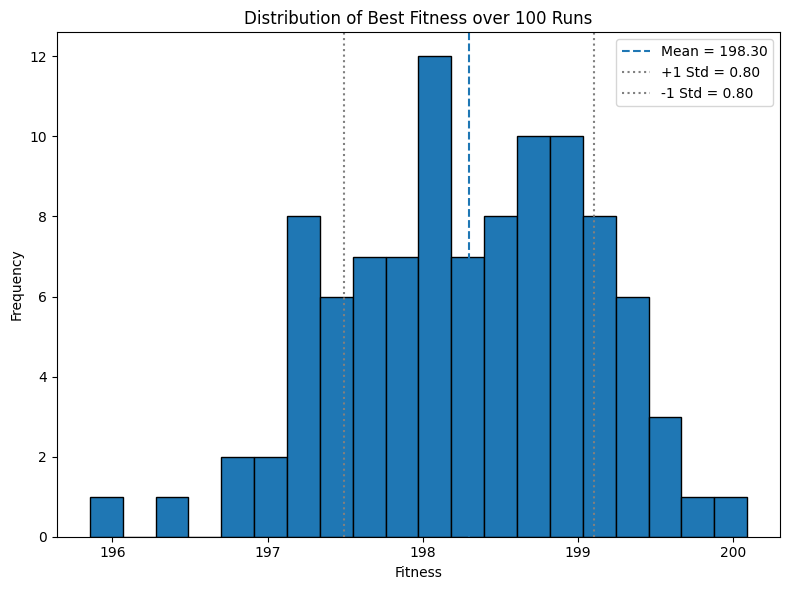

Mean fitness: 198.2980
Std deviation of fitness: 0.8041


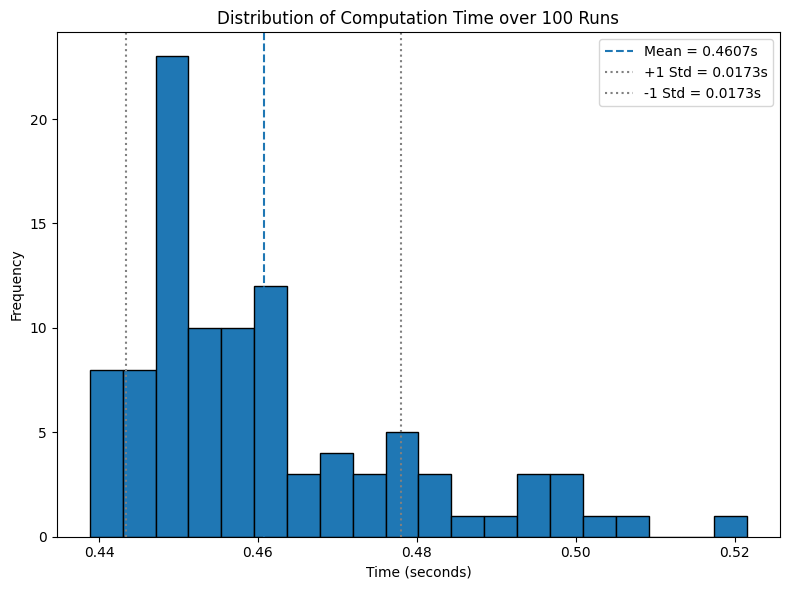

Mean computation time: 0.4607 seconds
Std deviation of time: 0.0173 seconds


(np.float64(198.2979992759397),
 np.float64(0.8040943586264374),
 np.float64(0.46073308229446414),
 np.float64(0.017339495769090427))

In [25]:
plot_distributions_2(initial_temp=100, num_of_cycle=300, runs=100, max_attempts=10)